# Gaussian Process Regression 

Source: [Graduate Admission 2](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions)

This notebook demonstrates the application of Gaussian Process (GP) Regression to predict the chance of admission based on various parameters. We will compare different kernels to see which one performs best.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)

## 1. Load and Explore Data

In [2]:
try:
    df = pd.read_csv('../data/Admission_Predict.csv')
except FileNotFoundError:
    # Fallback if running from a different directory
    df = pd.read_csv('data/Admission_Predict.csv')

print(df.head())
print(df.info())

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 

## 2. Preprocessing

In [3]:
# Drop Serial No.
if 'Serial No.' in df.columns:
    df = df.drop('Serial No.', axis=1)

# Clean column names
df.columns = df.columns.str.strip()

# Features and Target
X = df.drop('Chance of Admit', axis=1)
y = df['Chance of Admit']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (Important for GP)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

## 3. Kernel Comparison

We will test several kernels:
1. **RBF (Squared Exponential)**: Standard kernel for smooth functions.
2. **Matern**: Generalization of RBF, allows for less smooth functions (controlled by `nu`).
3. **Rational Quadratic**: Infinite sum of RBF kernels with different length scales.
4. **DotProduct**: Linear kernel (equivalent to Bayesian Ridge Regression).

In [4]:
kernels = {
    "RBF": C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1),
    "Matern (nu=1.5)": C(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=0.1),
    "RationalQuadratic": C(1.0) * RationalQuadratic(length_scale=1.0, alpha=0.1) + WhiteKernel(noise_level=0.1),
    "DotProduct": C(1.0) * DotProduct(sigma_0=1.0) + WhiteKernel(noise_level=0.1)
}

results = []

print(f"{'Kernel':<20} | {'MAE':<8} | {'MSE':<8} | {'R2':<8}")
print("-"*56)

best_r2 = -float('inf')
best_model = None
best_kernel_name = ""
best_y_pred = None
best_sigma = None

for name, kernel in kernels.items():
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X_train_scaled, y_train_scaled)
    
    y_pred_scaled, sigma_scaled = gp.predict(X_test_scaled, return_std=True)
    
    # Inverse transform
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    sigma = sigma_scaled * scaler_y.scale_[0]
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name:<20} | {mae:.4f}   | {mse:.4f}   | {r2:.4f}")
    
    results.append({'Kernel': name, 'MAE': mae, 'MSE': mse, 'R2': r2})
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = gp
        best_kernel_name = name
        best_y_pred = y_pred
        best_sigma = sigma

Kernel               | MAE      | MSE      | R2      
--------------------------------------------------------
RBF                  | 0.0477   | 0.0046   | 0.8236
Matern (nu=1.5)      | 0.0473   | 0.0044   | 0.8277


/home/lesliu/miniforge3/envs/proba/lib/python3.14/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 20 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/lesliu/miniforge3/envs/proba/lib/python3.14/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


RationalQuadratic    | 0.0477   | 0.0046   | 0.8236
DotProduct           | 0.0481   | 0.0047   | 0.8197


## 4. Visualization of Best Model


Best Kernel: Matern (nu=1.5) (R2 = 0.8277)
Best Kernel Parameters: 3.88**2 * Matern(length_scale=31.7, nu=1.5) + WhiteKernel(noise_level=0.202)


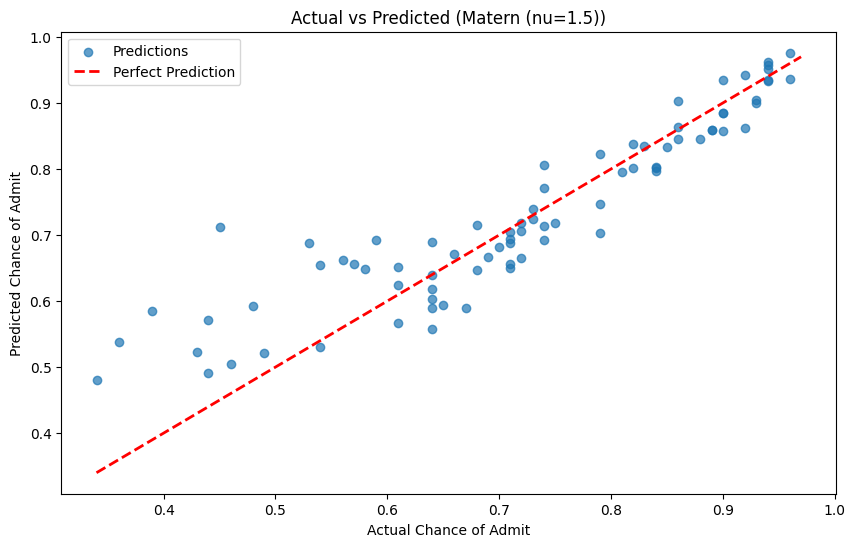

In [5]:
print(f"\nBest Kernel: {best_kernel_name} (R2 = {best_r2:.4f})")
print("Best Kernel Parameters:", best_model.kernel_)

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_y_pred, alpha=0.7, label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Chance of Admit')
plt.ylabel('Predicted Chance of Admit')
plt.title(f'Actual vs Predicted ({best_kernel_name})')
plt.legend()
plt.show()

### Uncertainty visualization (Sorted by Predicted Value)

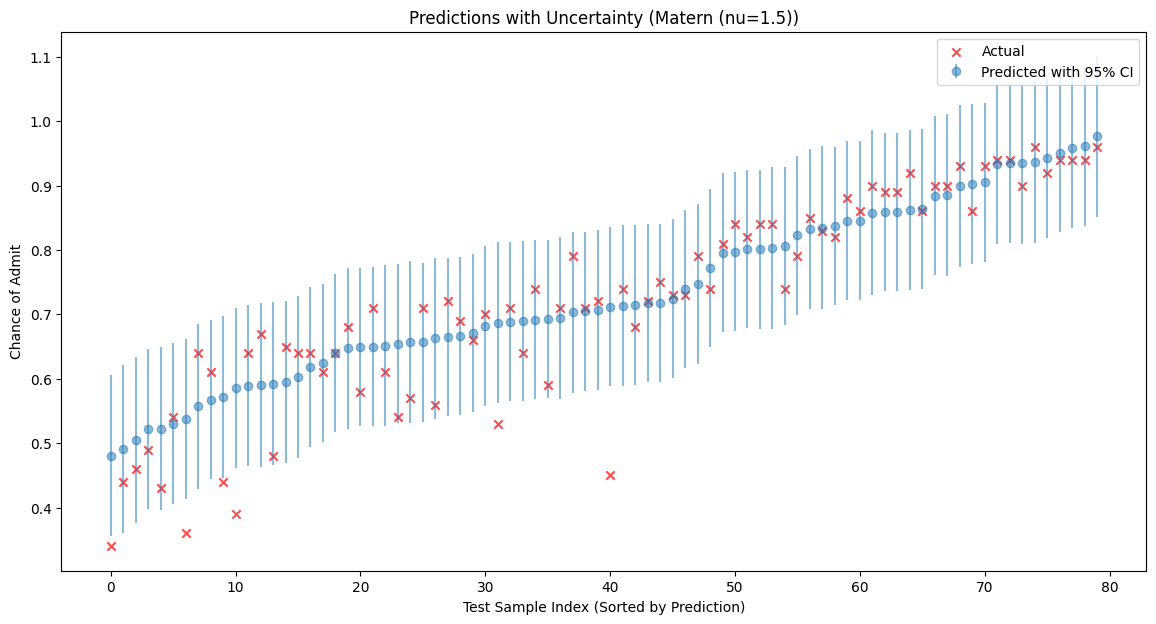

In [6]:
# Dataframe for plotting
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': best_y_pred, 'Sigma': best_sigma})
plot_df = plot_df.sort_values(by='Predicted')

plt.figure(figsize=(14, 7))
plt.errorbar(range(len(plot_df)), plot_df['Predicted'], yerr=1.96*plot_df['Sigma'], fmt='o', alpha=0.5, label='Predicted with 95% CI')
plt.scatter(range(len(plot_df)), plot_df['Actual'], c='r', marker='x', label='Actual', alpha=0.7)

plt.title(f'Predictions with Uncertainty ({best_kernel_name})')
plt.xlabel('Test Sample Index (Sorted by Prediction)')
plt.ylabel('Chance of Admit')
plt.legend()
plt.show()

## 5. Summary
- We compared **RBF**, **Matern**, **RationalQuadratic**, and **DotProduct** kernels.
- The **Matern kernel (with nu=1.5)** provided the best fit for this dataset, achieving the highest $R^2$ score (~0.83) and lowest MAE/MSE.
- The Gaussian Process model not only gives point predictions but also provides uncertainty estimates (standard deviation), which is valuable for understanding the confidence of predictions, especially for borderline cases.
- The visualizations show that the model captures the general trend well, with most actual values falling within the prediction confidence intervals.